In [1]:
# linear_interpolate

import numpy as np
from analytic_wavelet import linear_interpolate

a = 1
b = 7
t1 = 2
t2 = 4

t = np.array([t1, t2])
x = a * t + b

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = linear_interpolate(t[0], t[1], x[0], x[1], ti)
    assert(np.allclose(xi, a * ti + b))
    
a = 1 + 1j*4
b = 7 + 1j*2
x = a * t + b

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = linear_interpolate(t[0], t[1], x[0], x[1], ti)
    assert(np.allclose(xi, a * ti + b))

t0 = linear_interpolate(t[0], t[1], x[0], x[1])
x0 = linear_interpolate(t[0], t[1], x[0], x[1], t0)
assert(np.allclose(x0, 0))

print('linear_interpolate passed')

linear_interpolate passed


In [2]:
# quadratic interpolate
import numpy as np
from analytic_wavelet import quadratic_interpolate

a = 1
b = 7
c = -23

t1 = 2
t2 = 4
t3 = 8

t = np.array([t1, t2, t3])
x = a * t**2 + b * t + c

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = quadratic_interpolate(t[0], t[1], t[2], x[0], x[1], x[2], ti)
    assert(np.allclose(xi, a * ti ** 2 + b * ti + c))
    
a = 1 + 1j * 4
b = 7 + 1j * 2
c = -23 + 1j * 12
x = a * t**2 + b * t + c

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = quadratic_interpolate(t[0], t[1], t[2], x[0], x[1], x[2], ti)
    assert(np.allclose(xi, a * ti ** 2 + b * ti + c))

a = 1
b = 7
c = -23
x = a * t**2 + b * t + c
xe, te = quadratic_interpolate(t[0], t[1], t[2], x[0], x[1], x[2])

t = np.arange(-20, 20, 0.01)
x = a * t**2 + b * t + c
idx_min = np.argmin(x)
assert(np.isclose(x[idx_min], xe))
assert(np.isclose(t[idx_min], te))
print('quadratic_interpolate passed')

quadratic_interpolate passed


In [3]:
# rotate
import numpy as np
from analytic_wavelet import rotate, _rotate_main_angle

x = np.array([np.pi/2, -np.pi/2, np.pi, -np.pi, 2*np.pi, -2*np.pi, 0])
assert(np.allclose(rotate(x), np.array([1j, -1j, -1, -1, 1, 1, 1])))
x = np.arange(-3*np.pi, 3 * np.pi, 0.1)
assert(np.allclose(np.angle(rotate(x)), _rotate_main_angle(x)))
print('rotate passed')

rotate passed


In [4]:
# GeneralizedMorseWavelet amplitude
import numpy as np
from scipy.special import dawsn, eval_hermite, binom
from analytic_wavelet import GeneralizedMorseWavelet

gamma = np.arange(2, 10)
beta = np.arange(1, 11)
gamma, beta = np.meshgrid(gamma, beta)

morse = GeneralizedMorseWavelet(gamma, beta, is_bandpass_normalized=False)

# (10, 8)
omega = morse.peak_frequency()

d_omega = 0.01
# (10, 8, num_freq_steps)
omega_grid = np.expand_dims(omega, 2) * np.reshape(np.arange(0, 20 + d_omega / 2, d_omega), (1, 1, -1))

psi = (np.expand_dims(morse.amplitude(), 2) * omega_grid ** np.expand_dims(beta, 2)
       * np.exp(-omega_grid ** np.expand_dims(gamma, 2)))

psi_integral = np.sum(psi ** 2, axis=2) * d_omega * omega / (2 * np.pi)

assert(np.allclose(psi_integral, 1, atol=1e-2))
print('amplitude passed')

amplitude passed


In [5]:
# GeneralizedMorseWavelet heisenberg_box
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet
from scipy.integrate import trapz
from scipy.fftpack import fftshift, fft

t = np.arange(-500, 501)
gamma, beta = np.meshgrid(np.arange(2, 11, 2), np.arange(2, 11, 2))
morse = GeneralizedMorseWavelet(gamma, beta)

def _sigma(y, x):
    dx = x[1] - x[0]
    x = np.reshape(x, (1,) * (len(y.shape) - 1) + (len(x),))
    y = y / np.expand_dims(trapz(y, dx=dx, axis=-1), -1)
    mu = np.expand_dims(np.real(trapz(y * x, dx=dx, axis=-1)), -1)
    return np.squeeze(np.sqrt(trapz((x - mu) ** 2 * y, dx=dx, axis=-1)), axis=-1)
    
fs = 2 * np.pi / 20
psi_a, _ = morse.make_wavelet(len(t), fs)
sigma_t = _sigma(np.abs(psi_a)**2, t)
sigma_t = sigma_t * fs

fs = 2 * np.pi / 5
psi_b, _ = morse.make_wavelet(len(t), fs)
f = 2 * np.pi * fftshift(t / len(t))
sigma_f = _sigma(np.abs(fft(psi_b))**2, f)
sigma_f = sigma_f / fs

area, box_sigma_t, box_sigma_f = morse.heisenberg_box()

assert(np.allclose(sigma_t, box_sigma_t))
assert(np.allclose(sigma_f, box_sigma_f, atol=1e-3))
print('heisenberg_box passed')

heisenberg_box passed


In [6]:
# GeneralizedMorseWavelet moments
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet
import scipy.special

# energy cumulant
morse = GeneralizedMorseWavelet(gamma=np.array([3, 0.5, 9]), beta=np.array([2.0, 15.12, 0.751]))
omega = morse.peak_frequency()
_, _, sigma_f = morse.heisenberg_box()
moments, cumulants = morse.energy_cumulants(2)
assert(np.allclose(np.sqrt(cumulants[2] / omega ** 2), sigma_f))

# frequency moments
gamma, beta = np.meshgrid(np.arange(2, 10.05, .1), np.arange(1, 10.05, .1))
moments, cumulants = GeneralizedMorseWavelet(gamma=gamma, beta=beta).frequency_domain_cumulants(10)
for p in range(1, 11):
    frequency_moment = (2 * ((np.exp(1) * gamma) / beta) ** (beta / gamma) 
                        * (1 / (2 * np.pi * gamma)) * scipy.special.gamma((beta + 1 + p) / gamma))
    assert(np.allclose(moments[p], frequency_moment))

# numerical
gamma, beta = np.meshgrid(np.arange(2, 13, 2), np.arange(1, 11, 2))
omi = np.arange(0, 20.005, .01)
d_omi = omi[1] - omi[0]
omi = np.reshape(omi, (1, 1, -1))
morse = GeneralizedMorseWavelet(gamma, beta)
peak_frequency = np.expand_dims(morse.peak_frequency(), 2)
psi = (
    np.expand_dims(morse.amplitude(), 2) 
    * (peak_frequency * omi) ** np.expand_dims(beta, 2) 
    * np.exp(-(peak_frequency * omi) ** np.expand_dims(gamma, 2)))
peak_frequency = np.squeeze(peak_frequency, axis=2)
freq_1 = d_omi / (2 * np.pi) * peak_frequency ** 2 * np.sum(omi * psi, axis=2)
energy_1 = d_omi / (2 * np.pi) * peak_frequency ** 2 * np.sum(omi * psi ** 2, axis=2)
freq_2 = d_omi / (2 * np.pi) * peak_frequency ** 3 * np.sum(omi**2 * psi, axis=2)
energy_2 = d_omi / (2 * np.pi) * peak_frequency ** 3 * np.sum(omi**2 * psi ** 2, axis=2)

frequency_moments, _ = morse.frequency_domain_cumulants(2)
energy_moments, _ = morse.energy_cumulants(2)

assert(np.allclose(freq_1, frequency_moments[1]))
assert(np.allclose(energy_1, energy_moments[1]))
assert(np.allclose(freq_2, frequency_moments[2]))
assert(np.allclose(energy_2, energy_moments[2]))

# cumulants
gamma, beta = np.meshgrid(np.arange(2, 13, 2), np.arange(1, 11, 2))
moments, cumulants = GeneralizedMorseWavelet(gamma, beta).frequency_domain_cumulants(3)
assert(np.allclose(cumulants[0], np.log(moments[0])))
assert(np.allclose(cumulants[1], moments[1] / moments[0]))
assert(np.allclose(cumulants[2], moments[2] / moments[0] - (moments[1] / moments[0]) ** 2))
assert(np.allclose(
    cumulants[3], 
    2 * (moments[1] ** 3 / moments[0] ** 3) - 3 * moments[1] / moments[0] * moments[2] / moments[0] + moments[3] / moments[0]))

# alternate
moments, cumulants = GeneralizedMorseWavelet(gamma, beta).energy_cumulants(3)
a = GeneralizedMorseWavelet(gamma, beta).amplitude()
for order in range(4):
    assert(np.allclose(
        moments[order], 
        ((a ** 2) / (2 ** ((2 * beta + 1 + order) / gamma))) 
        * (1 / (2 * np.pi * gamma)) * scipy.special.gamma((2 * beta + 1 + order) / gamma)))

assert(np.allclose(
    cumulants[3], 
    ((moments[3] / moments[0]) 
     - 3 * ((moments[1] * moments[2]) / (moments[0] ** 2)) 
     + 2 * ((moments[1] ** 3) / (moments[0] ** 3)))))

# ratio
gamma, beta = np.meshgrid(np.arange(2, 12.25, 0.5), np.arange(1, 10.25, 0.5))
moments, cumulants = GeneralizedMorseWavelet(gamma, beta).energy_cumulants(2)
expected = np.exp(
    scipy.special.gammaln((2 * beta + 3) / gamma) 
    + scipy.special.gammaln((2 * beta + 1) / gamma) 
    - 2 * scipy.special.gammaln((2 * beta + 2) / gamma)) - 1
actual = (moments[2] / moments[0]) / np.square(moments[1] / moments[0]) - 1 
assert(np.allclose(expected, actual))

print('moments passed')

moments passed


In [19]:
# GeneralizedMorseWavelet make_wavelet
import numpy as np
from scipy.special import dawsn, eval_hermite, binom
from analytic_wavelet import GeneralizedMorseWavelet
from analytic_wavelet_transform_moments import first_central_diff

def scorer(z, n):
    # Orig comment:
    # This is not a very good way to compute the Scorer functions.
    # Need to set n really high to have to integral behave nicely.
    # Only used for testing purposes.
    z = np.reshape(z, (-1, 1))
    u = np.linspace(0, 10, n)
    du = u[1] - u[0]
    
    return (1 / np.pi) * du * np.sum(
        np.exp(-(np.tile(np.expand_dims(u, axis=0), (z.shape[0], 1)) ** 3 / 3) + (z * np.conj(u))), axis=1)


def hermite_polynomial(n, x):
    if n < 0:
        raise ValueError('n must be >= 0')
    result = np.zeros((n + 1,) + x.shape, x.dtype)
    result[0] = np.ones_like(x)
    if n == 0:
        return result
    result[1] = 2 * x
    if n == 1:
        return result
    for i in range(3, n + 1 + 1):
        result[i - 1] = 2 * x * result[i - 2] - 2 * (i - 2) * result[i - 3]
    return result


# test hermite_polynomial
t = np.arange(-2, 2.005, .01)
h = hermite_polynomial(4, t)
assert(np.allclose(h[0], np.ones_like(t)))
assert(np.allclose(h[1], 2 * t))
assert(np.allclose(h[2], 4 * t ** 2 - 2))
assert(np.allclose(h[3], 8 * t ** 3 - 12 * t))
assert(np.allclose(h[4], 16 * t ** 4 - 48 * t ** 2 + 12))


def dawsn_deriv(n, x):
    y = np.zeros_like(x)
    # z = [eval_hermite(i, x) for i in range(n + 1)]
    # jz = [eval_hermite(i, 1j * x) for i in range(n + 1)]
    z = hermite_polynomial(n, x)
    jz = hermite_polynomial(n, 1j * x)
    for k in range(1, n + 1):
        y = y + binom(n, k) * z[n - k] * ((1j ** (k - 1)) * jz[k - 1])
    return ((-1) ** n) * (z[n] * dawsn(x) - y)


# test dawsn_deriv
dt = 0.01
t = np.arange(-15, 15.005, dt)
dk1 = dawsn(t)
# avoid differentiation errors at edges
dk1[0] = np.nan   
dk1[-1] = np.nan

for k in range(1, 6):
    dk2 = dawsn_deriv(k, t)
    dk1 = np.gradient(dk1, dt)
    dk1[0] = np.nan
    dk1[-1] = np.nan
    err = np.nansum(np.abs(dk1 - dk2) ** 2) / np.nansum(np.abs(dk1) ** 2)
    assert(err < 1e-3)
    

# check energy == 1
psi, _ = GeneralizedMorseWavelet(gamma=2, beta=4, is_bandpass_normalized=False).make_wavelet(
    num_timepoints=1023, scale_frequencies=2*np.pi/np.logspace(np.log10(5),np.log10(40)), num_orthogonal_family_members=2)
assert(np.allclose(np.sum(np.abs(psi)**2, axis=-1), 1, atol=1e-4))


# check centering (odd num_timepoints)
psi, _ = GeneralizedMorseWavelet(gamma=2, beta=4).make_wavelet(
    num_timepoints=1023, scale_frequencies=2*np.pi/np.logspace(np.log10(5),np.log10(40)))
assert(np.all(np.max(np.abs(psi), axis=-1) == np.abs(psi[..., 1024//2 - 1])))


# check centering (even num_timepoints)
psi, _ = GeneralizedMorseWavelet(gamma=2, beta=4).make_wavelet(
    num_timepoints=1024, scale_frequencies=2*np.pi/np.logspace(np.log10(5),np.log10(40)))
assert(np.all(np.logical_or(
    np.max(np.abs(psi), axis=-1) == np.abs(psi[..., 1024//2-1]),
    np.max(np.abs(psi), axis=-1) == np.abs(psi[..., 1024//2]))))


# test scorer? Not sure what this is doing
t = np.arange(-50, 51, 1)
psi_1, _ = GeneralizedMorseWavelet(gamma=3, beta=0).make_wavelet(
    len(t), GeneralizedMorseWavelet(gamma=3, beta=1).peak_frequency())
c = 3 ** (1 / 3)
psi_2 = (1 / c) * scorer(1j * t / c, 1000)
err = np.sum(np.abs(psi_1 - np.expand_dims(psi_2, 0)) ** 2, axis=1) / np.sum(np.abs(psi_1) ** 2, axis=1)
assert(err < 1e-1)


# test cauchy
dt = .01
t = np.arange(-25, 25.005, dt)
psi_1, _ = GeneralizedMorseWavelet(gamma=1, beta=0).make_wavelet(
    len(t), GeneralizedMorseWavelet(gamma=1, beta=1).peak_frequency() * dt)
psi_1 /= dt
psi_2 = (1 / np.pi) * (1 / (1 - 1j * t))
err = np.sum(np.abs(psi_1 - psi_2) ** 2, axis=1) / np.sum(np.abs(psi_1) ** 2, axis=1)
assert(err < 1e-1)


# test gaussian
dt = 0.1
t = np.arange(-50, 50.05, dt)
psi_1, _ = GeneralizedMorseWavelet(gamma=2, beta=0).make_wavelet(
    len(t), GeneralizedMorseWavelet(gamma=2, beta=1).peak_frequency() * dt)
psi_1 /= dt
psi_2 = (1 / (2 * np.sqrt(np.pi))) * (np.exp(-(t / 2) ** 2) + 1j * dawsn(t / 2) * (2 / np.sqrt(np.pi)))
err = np.sum(np.abs(psi_1 - psi_2) ** 2, axis=1) / np.sum(np.abs(psi_1) ** 2, axis=1)
assert(err < 1e-1)


# test dawson
dt = 0.01
t = np.arange(-15, 15.005, dt)
order = 5
herm = hermite_polynomial(order + 1, t / 2)
herm = herm[1:]

g = np.exp(-(t ** 2 / 4))
for k in range(1, order + 1):
    d = dawsn_deriv(k, t / 2)
    coeff = (1 / (4 * np.sqrt(np.pi))) * GeneralizedMorseWavelet(gamma=2, beta=k).amplitude() * (1j / 2) ** k
    psi_1_temp, _ = GeneralizedMorseWavelet(gamma=2, beta=k).make_wavelet(
        len(t), GeneralizedMorseWavelet(gamma=2, beta=k).peak_frequency() * dt)
    psi_1 = psi_1_temp[0] / dt
    psi_2 = coeff * (g * herm[k - 1] + 1j * (-1) ** k * d * (2 / np.sqrt(np.pi)))
    err = np.sum(np.abs(psi_1 - psi_2) ** 2) / np.sum(np.abs(psi_1) ** 2)
    assert(err < 1e-3)


# admissability
gamma, beta = np.meshgrid(np.arange(1, 12), np.arange(1, 11))
gamma = np.reshape(gamma, -1)
beta = np.reshape(beta, -1)
num_timepoints = 1000
omega = np.arange(0, 1, 1 / num_timepoints)
omega[0] = 1e-4
dt = 1 / 10
for g, b in zip(gamma, beta):
    morse = GeneralizedMorseWavelet(g, b)
    _, psi = morse.make_wavelet(num_timepoints, morse.peak_frequency() * dt)
    psi = psi ** 2 / omega
    c_psi_1 = np.sum(psi, axis=1) / num_timepoints
    c_psi_2 = morse.amplitude() ** 2 * (1 / (g * 2 ** (2 * b / g))) * scipy.special.gamma((2 * b) / g)
    assert(np.allclose(c_psi_1, c_psi_2, atol=1e-2))

    
# fft
fs = 1 / np.logspace(np.log10(5), np.log10(40)) 
num_timepoints = 1023
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(num_timepoints, fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(num_timepoints + 1, fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))
psi, psi_f = GeneralizedMorseWavelet(1, 4).make_wavelet(num_timepoints, -fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(num_timepoints + 1, -fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))

print('make_wavelets passed')

make_wavelets passed


C:\Users\danrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\danrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


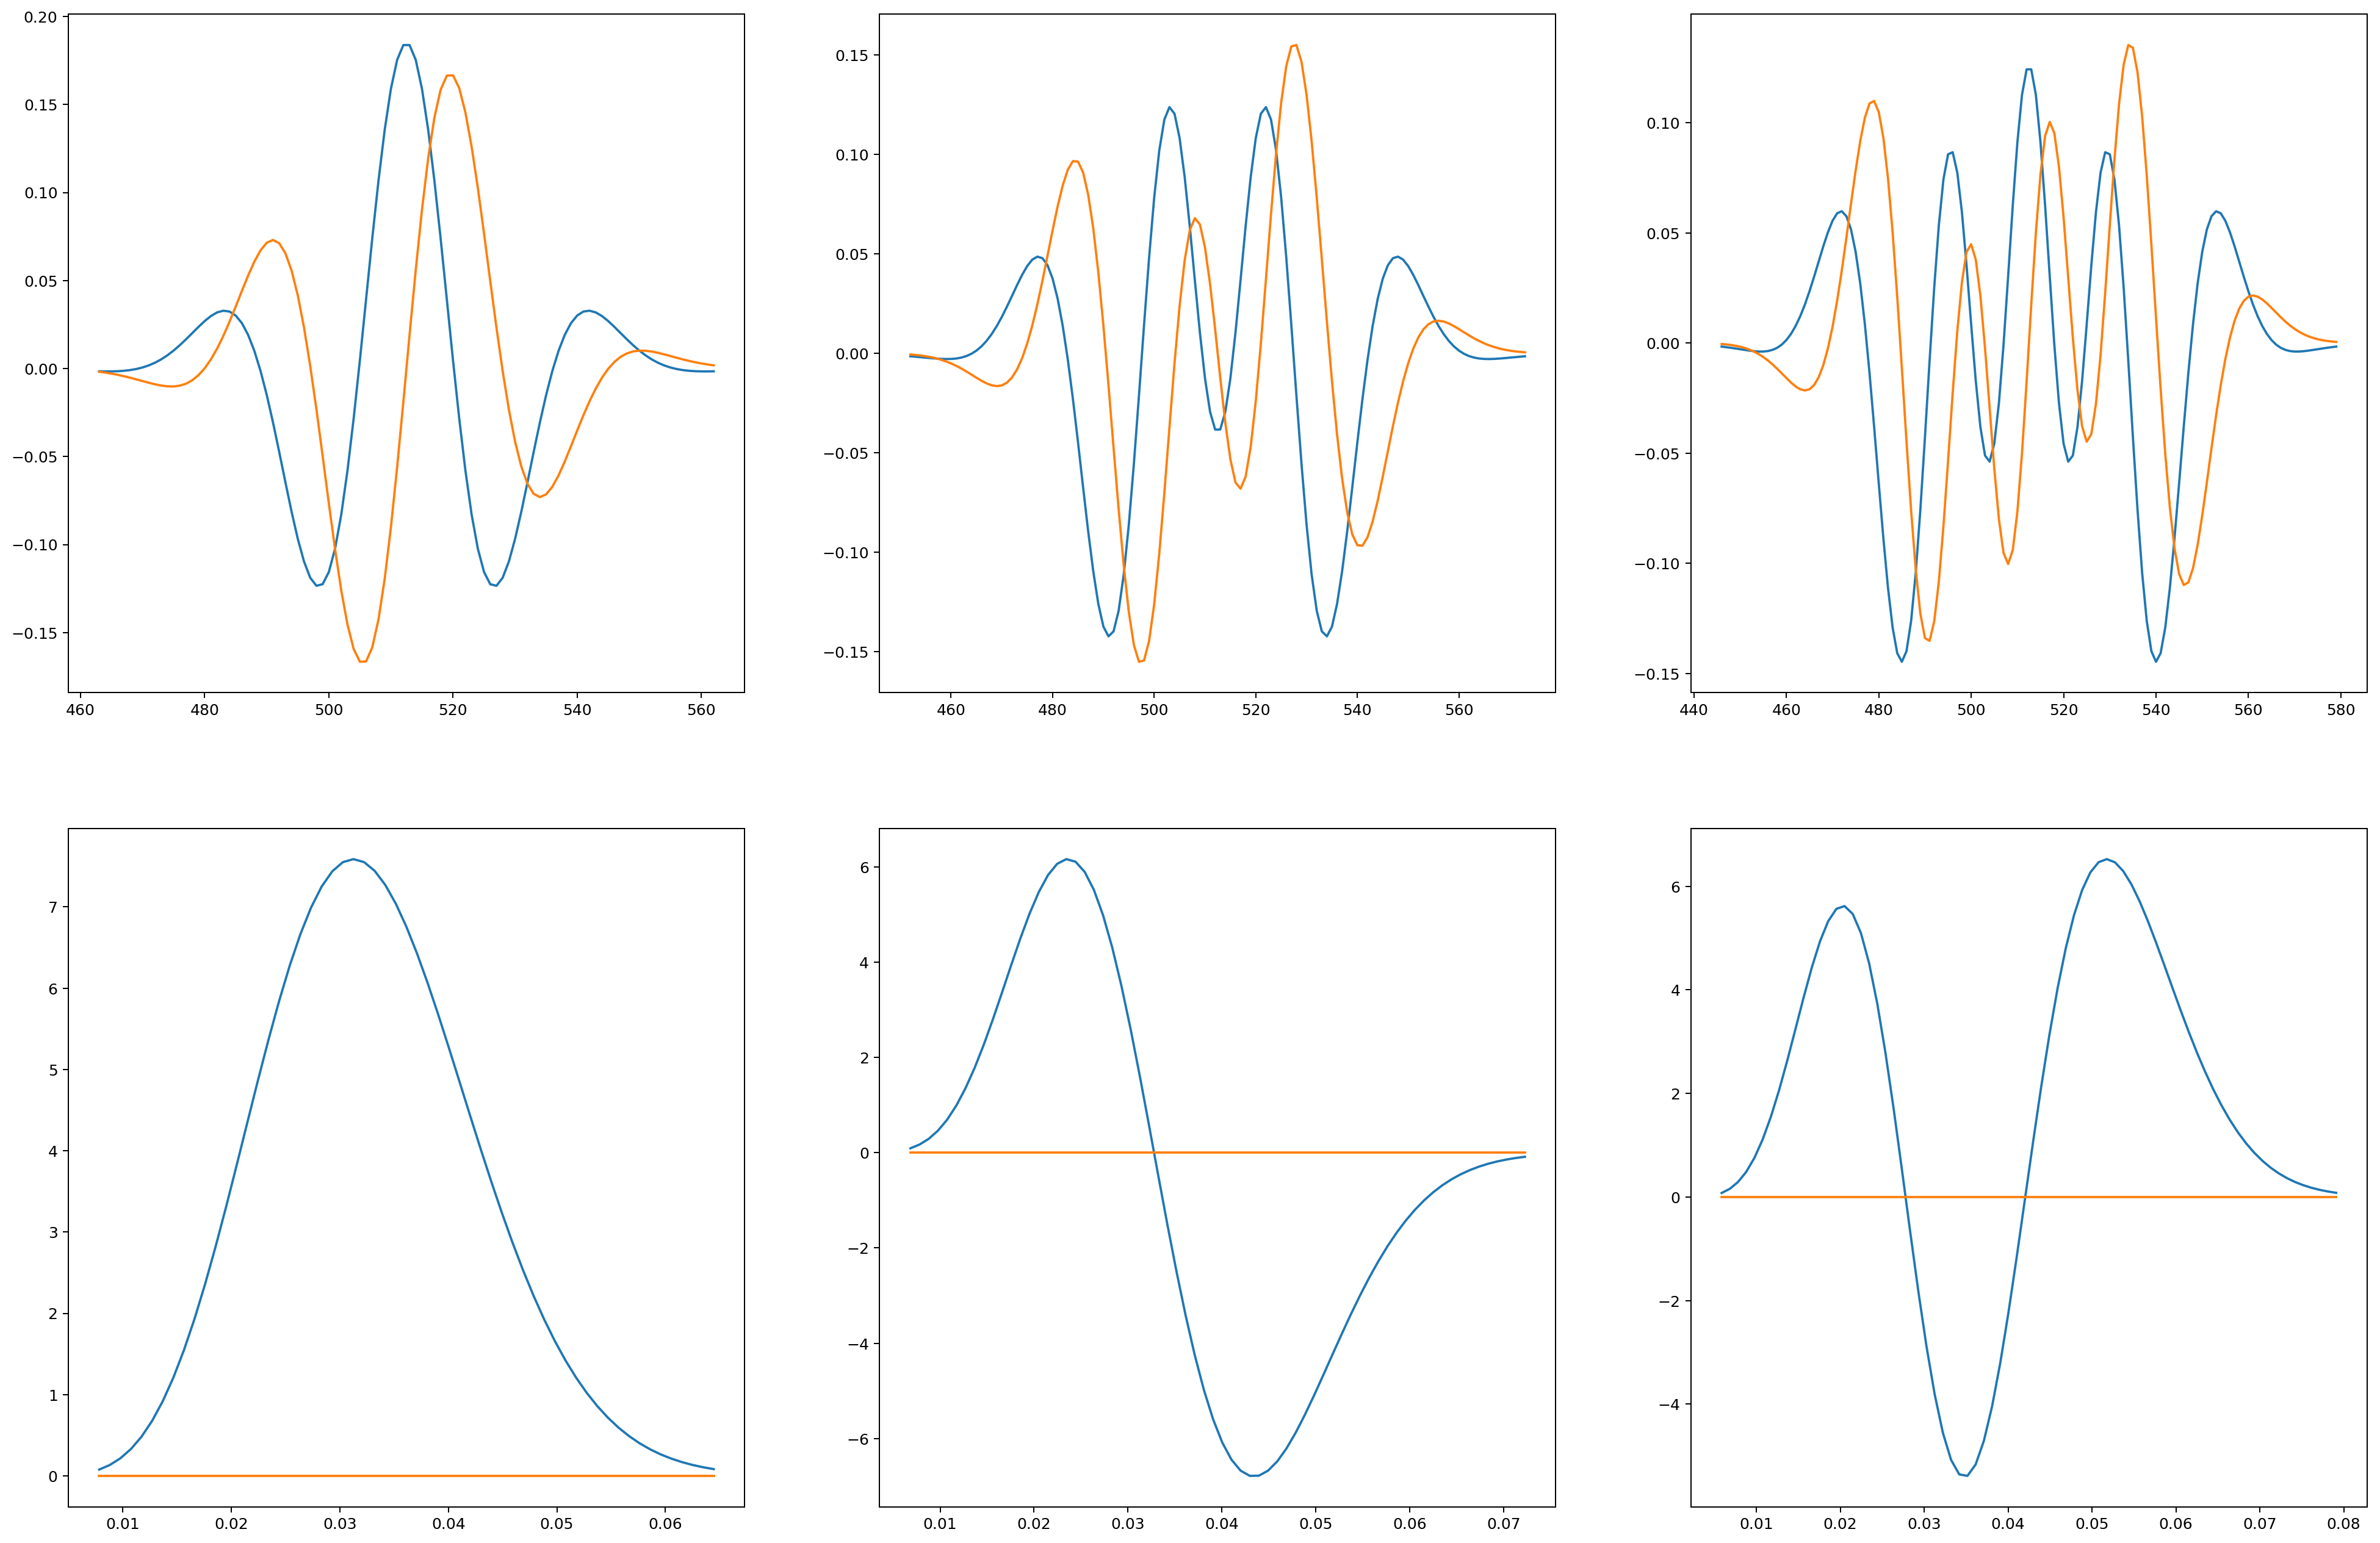

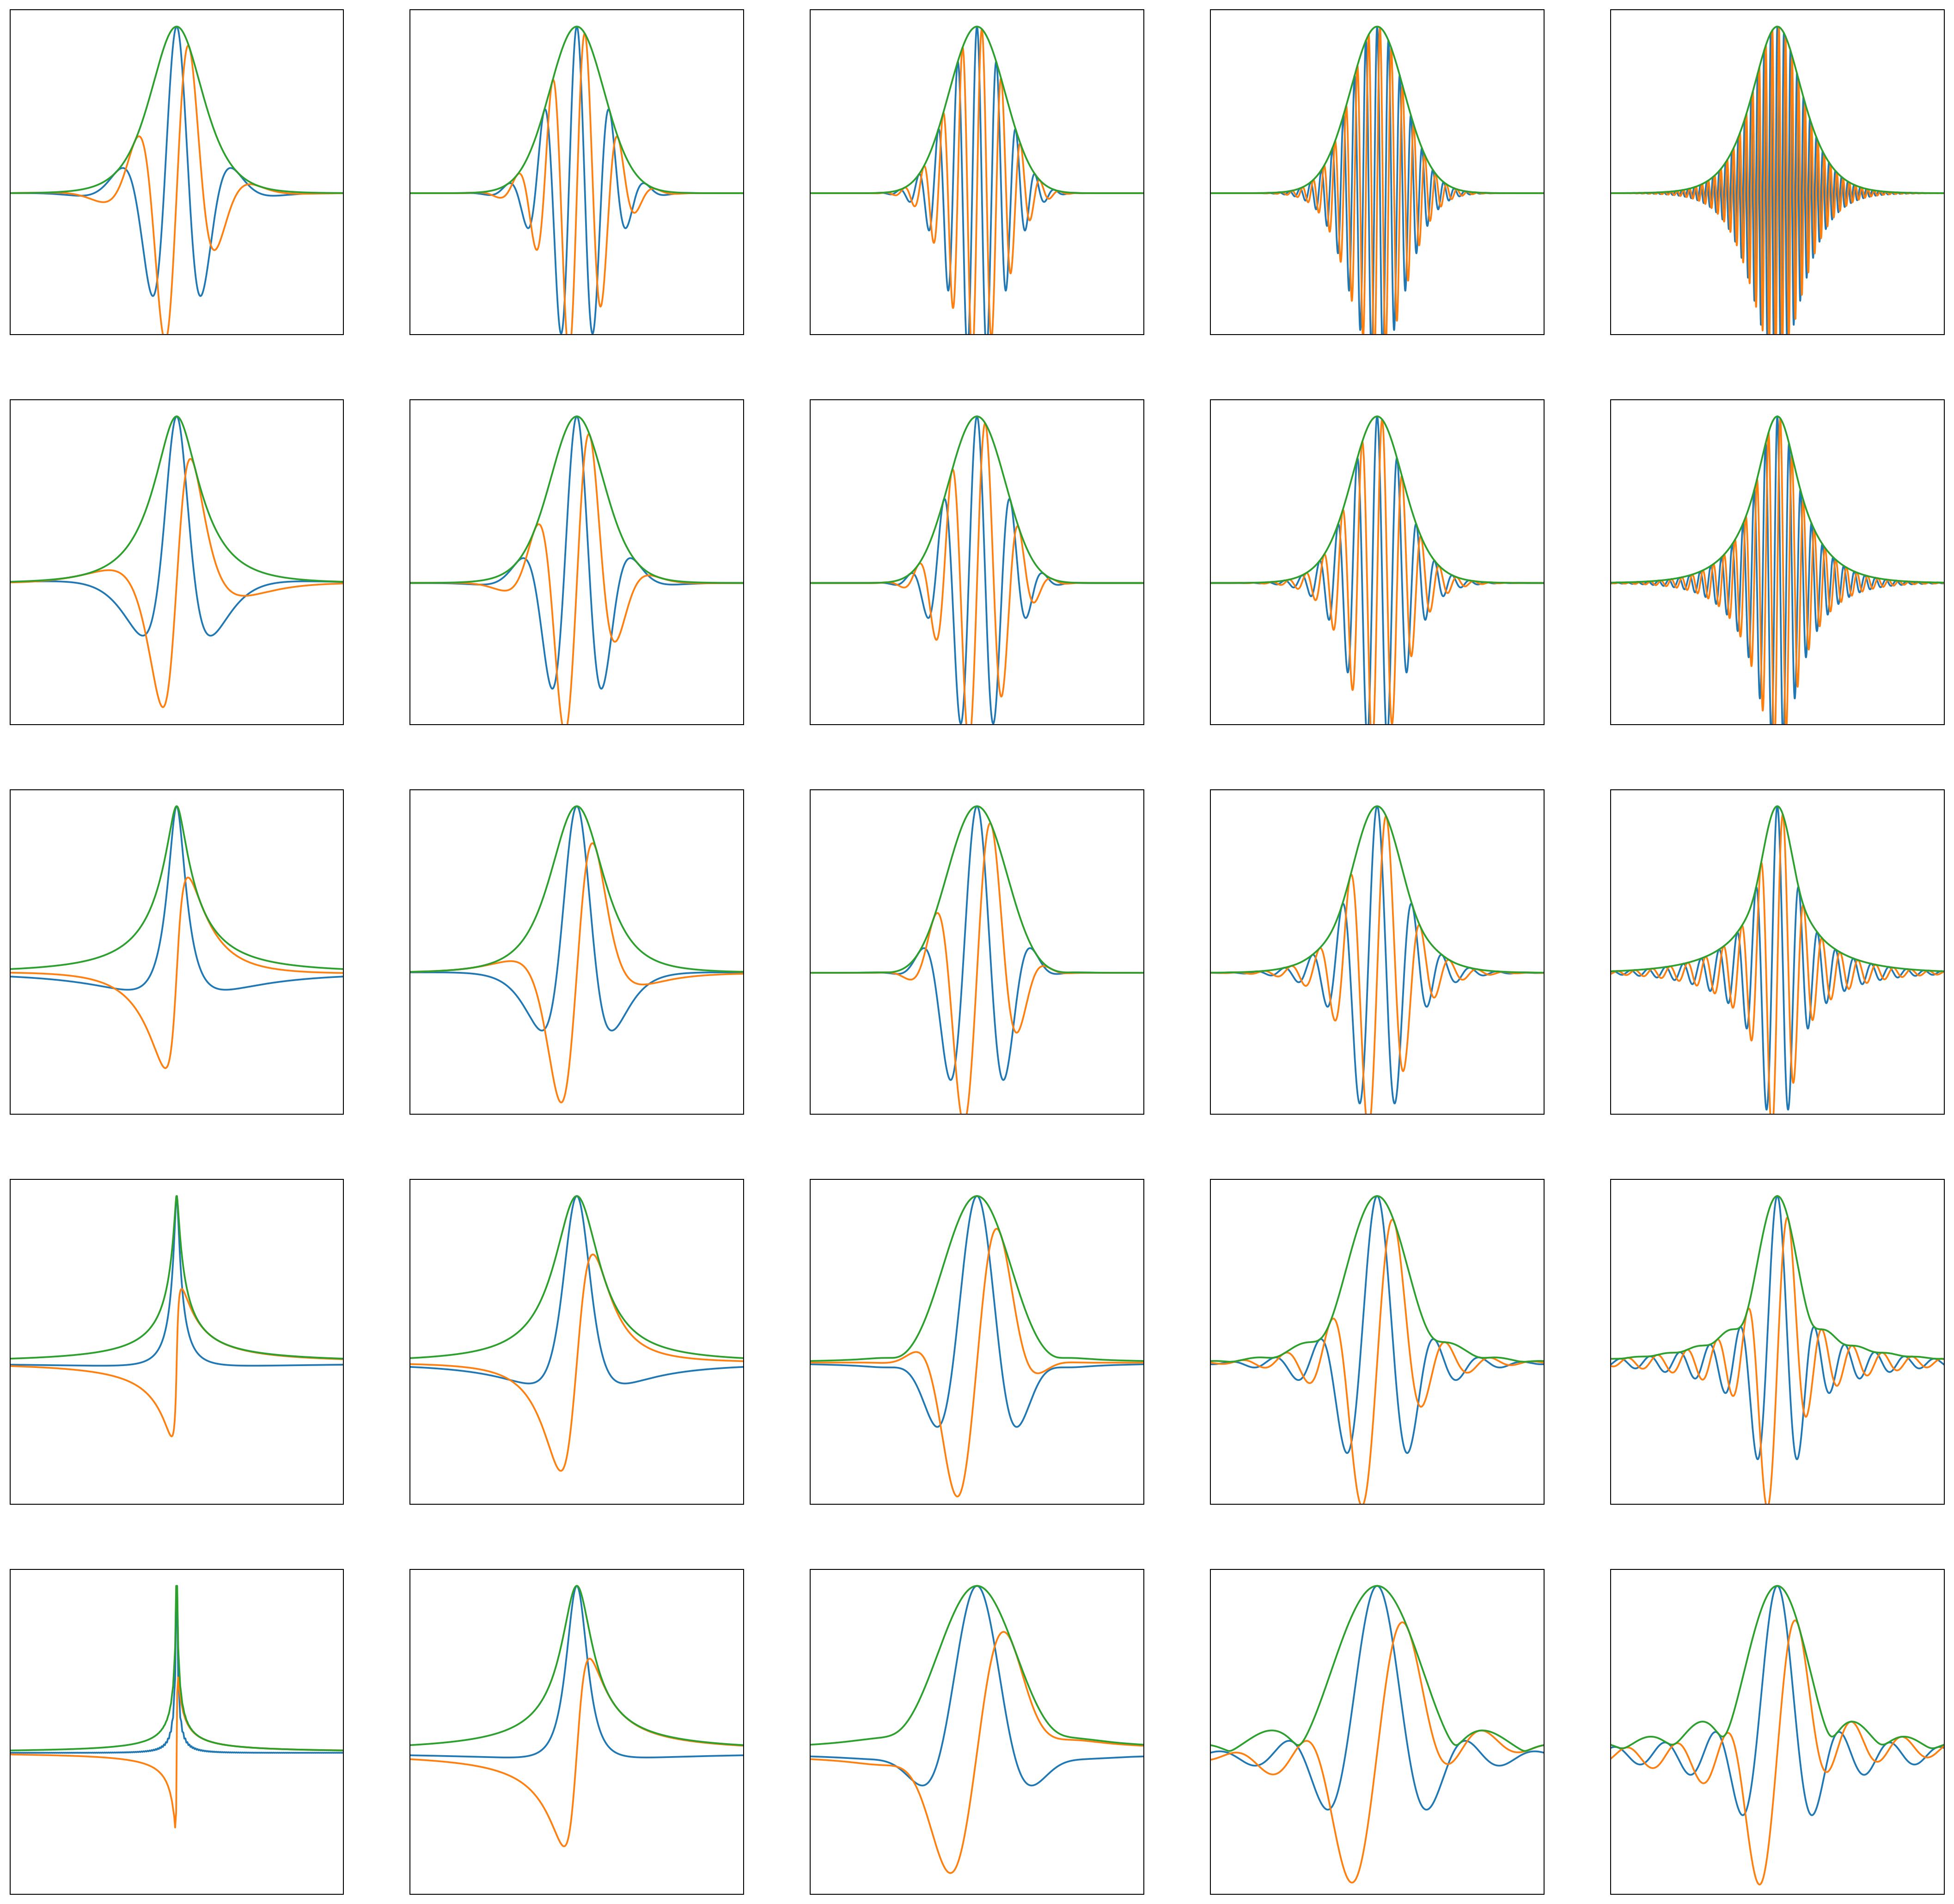

In [63]:
from matplotlib import pyplot as plt, gridspec
from scipy.fftpack import fftshift

num_timepoints = 256 * 4
fs = 2 * np.pi / 8 / 4
psi, psi_f = GeneralizedMorseWavelet(gamma=2, beta=5, is_bandpass_normalized=False).make_wavelet(
    num_timepoints=num_timepoints, scale_frequencies=fs, num_orthogonal_family_members=3)
# psi_f = fftshift(psi_f)

def uv_plot(ax, x, y):
    u = np.real(y)
    v = np.imag(y)
    rel_u = np.abs(u) / np.max(np.abs(u))
    rel_v = np.abs(v) / np.max(np.abs(v))
    indices_plot = np.flatnonzero(np.logical_or(rel_u >= 0.01, rel_v >= 0.01))
    start, stop = np.min(indices_plot), np.max(indices_plot) + 1
    ax.plot(x[start:stop], u[start:stop])
    ax.plot(x[start:stop], v[start:stop])

t = np.arange(1, num_timepoints + 1)
# t = t - np.mean(t)
# t = t * fs
# t = t / (GeneralizedMorseWavelet(2, 5).time_domain_width() / np.pi)
# indices_plot = np.nonzero(np.logical_and(t >= -3, t <= 3))
# start, stop = np.min(indices_plot), np.max(indices_plot) + 1
f = np.arange(0, 1, 1 / num_timepoints)

fig = plt.figure(figsize=(27, 18), dpi=180)
grid = gridspec.GridSpec(2, 3)

for i in range(6):
    row, col = divmod(i, 3)
    ax = fig.add_subplot(grid[row, col])
    x = t if row == 0 else f
    y = psi if row == 0 else psi_f
    y = y[col, 0]
    uv_plot(ax, x, y)

plt.show()
    
fig = plt.figure(figsize=(30, 30), dpi=180)
grid = gridspec.GridSpec(5, 5)
num_timepoints = 2 ** 16
fs = 1 / 512
t = np.arange(1, num_timepoints + 1)
t = t - np.mean(t)
t = t * fs
gamma_beta = [1/3, 1, 3, 9, 27]
for i, b in enumerate(reversed(gamma_beta)):
    for j, g in enumerate(gamma_beta):
        morse = GeneralizedMorseWavelet(g, b)
        p = morse.time_domain_width()
        psi, _ = morse.make_wavelet(num_timepoints, 2 * np.pi * fs)
        ax = fig.add_subplot(grid[i, j])
        x = np.concatenate([np.real(psi), np.imag(psi), np.abs(psi)], axis=0).T / np.max(np.abs(psi))
        ax.plot(t / (p / np.pi), x)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-0.85, 1.1)
        ax.set_xticks([])
        ax.set_yticks([])
